In [1]:
from sklearn import svm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from casadi import MX, Function, vcat, exp, norm_2
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from drccp.utils import get_project_root

In [2]:
from drcc_mpc.constraints import DifferentiableConstraint
from drcc_mpc.dr_mpc import DRCVaRTubeMPC, exponential_constraint
from drccp.casadi_utils import NNCasadi
from drcc_mpc.dynamics import LTIDynamics, NormalNoise, UniformNoise, Trajectory
from drcc_mpc.constraint_sets import Box
from drccp_utils.rkhs_utils import median_heuristic

In [3]:
class ShallowNetwork(nn.Module):
    """
    Neural Network model for constraint learning.
    """
    def __init__(self, in_dim, out_dim):
        super(ShallowNetwork, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.relu_stack = nn.Sequential(
            nn.Linear(in_dim, 8),
            nn.ELU(),
            nn.Dropout(0.1),
#             nn.Linear(8, 8),
#             nn.ReLU(),
            nn.Linear(8, out_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        coef = self.relu_stack(x)
        return coef

In [4]:
def make_constraint_data(center, size, n_points):
    """
    Create data to train an svm.

    Parameters
    ----------
    center: ndarray
        (dim,)
    size: ndarray
        (dim,)
    n_points: int

    Returns
    -------
    X: ndarray
        (n_points, dim)
    Y: ndarray
        (n_points, 1)
    """
    xx = np.linspace(center - size*0.7, center + size*0.7, num=int(np.sqrt(n_points)))
    x, y = np.meshgrid(xx[:, 0], xx[:, 1])
    X = np.vstack((x.ravel(), y.ravel())).T
    x_delta = 1 * np.random.uniform(-1, 1, size=X.shape)
    Y = np.logical_and(np.abs(X[:, 0] - center[0]) <= size[0] / 2,
                       np.abs(X[:, 1] - center[1]) <= size[1] / 2)
    X += x_delta
    return X, Y.reshape((-1,1))

In [5]:
def train_svm(c, gamma, X, Y):
    clf = svm.SVC(C=c, gamma=gamma)
    clf.fit(X, Y)
    return clf

In [6]:
def casadi_svm(clf):
    dim = clf.support_vectors_.shape[1]
    x = MX.sym('x', dim)
    y = MX.sym('y', dim)
    casadi_rbf = Function('rbf', [x, y],
                          [exp(-clf.gamma * norm_2(x-y)**2)])
    z = MX.sym('z', dim)
    e = MX.sym('e', dim)
    ki = vcat([casadi_rbf(z + e, s_vec) for s_vec in clf.support_vectors_])
    y_pred = clf.dual_coef_ @ ki + clf.intercept_
    cas_svm = Function('svm', [z, e], [-y_pred])
    return cas_svm

In [7]:
def get_cas_svm(X, Y):
    _, gamma = median_heuristic(X, X)
    clf = train_svm(10, gamma, X, Y)
    return casadi_svm(clf), clf, X, Y

In [8]:
class ConstraintDataset(Dataset):
    def __init__(self, decision_vars, output):
        self.x = torch.from_numpy(decision_vars).float()
        self.y = torch.from_numpy(output).float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx, :]

In [9]:
def train(dataset, epochs, model_params, lr=1e-3, batch_size=10):
    model = ShallowNetwork(**model_params)
    model.train()
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    for epoch in range(epochs):
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            pred = model(X)
            # Compute prediction error
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}  [{epoch:>5d}/{epochs:>5d}]")
    model.eval()
    return model.to("cpu")

In [10]:
center = np.array([5, 0])
size = np.array([20, 6])
n_points = 500
X, Y = make_constraint_data(center, size, n_points)
dataset = ConstraintDataset(X, np.asarray(Y, dtype=np.float))
model_params = {
    'in_dim': X.shape[1],
    'out_dim': Y.shape[1]
}

In [11]:
# model = train(dataset, 1000, model_params)
cas_svm, svm_model, _, _ = get_cas_svm(X, Y)

/home/nemo/py_env/mpc_py/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


in_t = torch.Tensor([0, 0])

out = model(in_t)
print(model.backward(torch.ones(1), retain_graph=True))
print(out.grad)

In [12]:
# cas_constraint = NNCasadi("NN_constraint", model, {"enable_fd": True})
cas_constraint = cas_svm
# x_lvl = -4
# growth_rate = 0.1
# cas_constraint = exponential_constraint(x_lvl, growth_rate)

In [13]:
dim_x = 2
dim_u = 1
dim_noise = 2
x0 = np.array([10, 0.0])
alpha = 0.05
n_samples = 10
horizon = 10
total_steps = 10
kernel = 'rbf'
kernel_param = 1

# define dynamics matrices
A = np.array([[1, 1], [0, 1]])
B = np.array([[0.5], [1]])
Q = np.eye(dim_x)
R = np.eye(dim_u)

# Noise
normal_param = {'mean': np.array([0.0, 0.0]),
                'cov': 0.1 * np.eye(2)}
normal_noise = NormalNoise(mean=normal_param['mean'],
                           cov=normal_param['cov'])
test_noise = NormalNoise(mean=normal_param['mean'],
                         cov=normal_param['cov'])
test_noise.set_mean(-0.5 * np.ones_like(normal_param['mean']))
test_noise.set_cov(0.1 * np.ones(normal_param['cov'].shape))

# Dynamics
lti_dyn = LTIDynamics(x0=x0,
                      A=A,
                      B=B,
                      D=np.eye(dim_noise),
                      add_noise=normal_noise,
                      multi_noise=None)

test_dyn = LTIDynamics(x0=x0,
                       A=A,
                       B=B,
                       D=np.eye(dim_noise),
                       add_noise=test_noise,
                       multi_noise=None)

epsilon = 1
input_constraint = Box(dim_u, [-100], [100])

In [14]:
mpc = DRCVaRTubeMPC(
    dynamics=lti_dyn,
    horizon=horizon,
    task_length=total_steps,
    n_scenarios=n_samples,
    noise=normal_noise,
    Q=Q, R=R,
    state_constraint=cas_constraint,
    input_constraint=input_constraint,
    alpha=alpha,
    epsilon=epsilon,
    kernel=kernel,
    kernel_param=1
)

In [15]:
mpc.setup_mpc(horizon=horizon,
              n_samples=n_samples,
              task_length=total_steps,
              alpha=alpha,
              epsilon=epsilon)
mpc.initialize(x0)
traj = [test_dyn.get_state()]
actions = []
for i in range(total_steps):
    print("{}-th mpc-iteration".format(i))
    actions.append(mpc.solve_mpc_iteration(test_dyn.get_state(), i))
    traj.append(test_dyn.act(actions[-1]))
mpc.trajectory.add(state=test_dyn.get_state(), nominal=mpc.nominal_state)

0-th mpc-iteration

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

1-th mpc-iteration
2-th mpc-iteration
3-th mpc-iteration
4-th mpc-iteration
5-th mpc-iteration
6-th mpc-iteration
7-th mpc-iteration
8-th mpc-iteration
9-th mpc-iteration


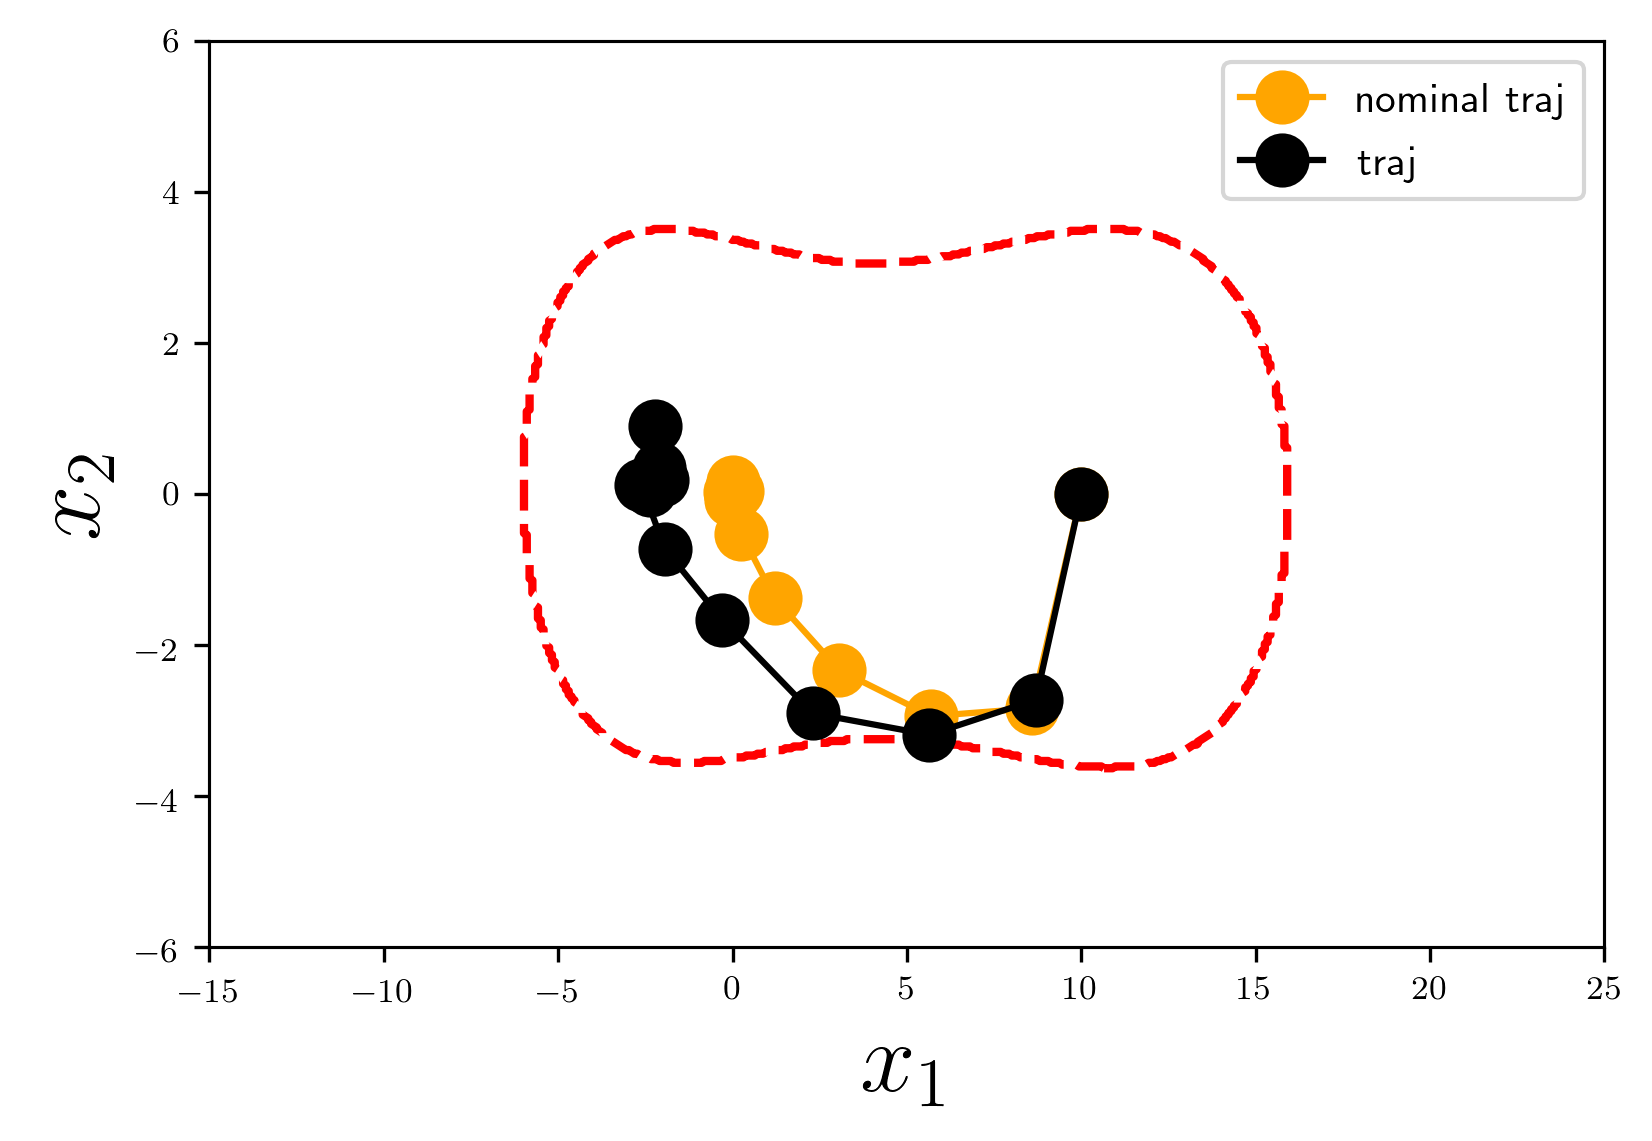

NameError: name 'name' is not defined

In [18]:
root = get_project_root()
plt.style.use(root / 'plt_style/jz.mplstyle')
fig, ax = plt.subplots()
xx, yy = np.meshgrid(np.linspace(center[0] - size[0],
                                 center[0] + size[0], 500),
                     np.linspace(center[1] - size[1],
                                 center[1] + size[1], 500))
X_plot = np.c_[xx.ravel(), yy.ravel()]
# Z = model(torch.from_numpy(X_plot).float()).detach().numpy()
Z = np.asarray(svm_model.predict(X_plot), dtype=np.float)
Z = Z.reshape(xx.shape)
# norm = colors.TwoSlopeNorm(vmin=np.min(Z), vcenter=0.5, vmax=np.max(Z))

# im = plt.imshow(Z, interpolation='nearest',
#                 extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#                 aspect='auto', alpha=0.5,
#                 origin='lower', cmap=plt.cm.PuOr_r, norm=norm)

contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors=['r'],
                       linestyles='dashed')
# plt.scatter(X[:, 0], X[:, 1], c=Y)
mpc.plot_trajectory(constraint=None, fig=fig, ax=ax)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlim(-7, 17)
ax.set_ylim(-5, 5)
plt.savefig('drcc_mpc.pdf'.format(name), dpi=300)
